In [5]:
import os 
import pandas as pd 
import numpy as np
import string
#Allows for threads to execute

### Setup Word Embedding Model

In [6]:
#This captures the individual value for each word rather than the global context
def create_glove_embeddings(file_path):
    index = {}
    with open(file_path, 'r') as file:
        for line in file:
            #cotains and word and its GloVe embeddings
            values = line.split()
            word = values[0]
            #Converts everything (except the word) into 
            #a numpy array that represents this words embeddings
            vector = np.asarray(values[1:], dtype='float32')
            #Creates a dictionary (key: word, value: vector of numbers)
            index[word] = vector
    return index

#Loads the embedding model we are using
glove_embeddings = create_glove_embeddings('glove.6B.100d.txt')

### Set up Dataframe

In [7]:

def review_embedding(review, glove_embeddings, dimension):
    word_embeddings = []
    words = review.split()
    for word in words: 
        #Cleans words - lowers all and gets rid of punctuation
        word = word.lower().strip(string.punctuation)
        #Looks up the word embedding value for each word
        #and sets the word to zero if the word is not found
        #Could lead to some accuracy problems but this is the norm
        #if the word is not found
        embedding = glove_embeddings.get(word, np.zeros(dimension))
        word_embeddings.append(embedding)
        #This averaging gets rid of some of the neseccary context,
        #however it might be sufficient for this project
    return np.mean(word_embeddings, axis=0)

def get_review(folderPath, classification, glove_embeddings):
    data = []
    dimension = 100
    for filename in os.listdir(folderPath):
        if filename.endswith(".txt"): 
            filePath = os.path.join(folderPath, filename)
            with open(filePath, 'r') as file:
                review = file.read().strip()
                #Calls the embedding model to convert the words into vectors
                embedding = review_embedding(review, glove_embeddings, dimension)
                #Appends a list inside of the data list consisting of the embedding vector and classification
                data.append([embedding, classification])
    return data

#1 being positive 0 being negative
positive_data = get_review('train_pos', '1', glove_embeddings)
negative_data = get_review('train_neg', '0', glove_embeddings)

combined_data = positive_data + negative_data

dataframe = pd.DataFrame(combined_data, columns=['review','classification'])

print(dataframe.head())
print(dataframe.shape)

                                              review classification
0  [-0.16359946, 0.11859289, 0.33264115, -0.35113...              1
1  [-0.07534258007156068, 0.07291057116789632, 0....              1
2  [-0.058315636623989454, 0.1340152359482917, 0....              1
3  [-0.08072773276773446, 0.18577787698967155, 0....              1
4  [-0.06717038917445785, 0.14868051377642486, 0....              1
(25000, 2)


### Divide dataframe into test and train data

In [8]:
from sklearn.model_selection import train_test_split
X = []
y = []

# Iterates through each row in combined data
for review, classification in combined_data:
    #review
    X.append(review)
    #classification
    y.append(classification)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### SVM: Fitting The Model

In [9]:
from sklearn import svm
#SVC is support vector classifcation
# kernal: mathematical function to map input to high dimension spaces 
# linear: typically good for high dimensions and text classication

#C - regularization parameter. Must be positive 
    #higher gives less regularization (overfitting)
svm_classifier = svm.SVC(kernel = "linear")
svm_classifier.fit(X_train,y_train)

SVC(kernel='linear')

### SVM: Testing the model

In [10]:
#Creates predictions for the testing data based on the 
#fitted model
predict_svm = svm_classifier.predict(X_test)
print(predict_svm)

['0' '1' '0' ... '1' '1' '1']


### SVM: Accuracy

In [11]:
from sklearn.metrics import accuracy_score 
svm_accuracy = accuracy_score(y_test, predict_svm)
print(f"Accuracy of SVM model {svm_accuracy}")

Accuracy of SVM model 0.79696


### K-NN (K-Nearest Neighbor)

In [12]:
#Test for K-NN
from sklearn.neighbors import KNeighborsClassifier 
neigh_classifier = KNeighborsClassifier(n_neighbors=50)
neigh_classifier.fit(X_train,y_train)
predict_knn = neigh_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, predict_knn)
print(f"Accuracy of K-nn model {knn_accuracy}")

Accuracy of K-nn model 0.73696


### Gaussian Naive Bayes Classifier 

In [13]:
#Test for Naive Bayes Classifer
from sklearn.naive_bayes import GaussianNB
naive_classifier = GaussianNB()
naive_classifier.fit(X_train,y_train)
predict_naive = naive_classifier.predict(X_test)
naive_accuracy = accuracy_score(y_test, predict_naive)
print(f"Accuracy of K-nn model {naive_accuracy}")

Accuracy of K-nn model 0.6904


### Visual Representation: MatPlotLib

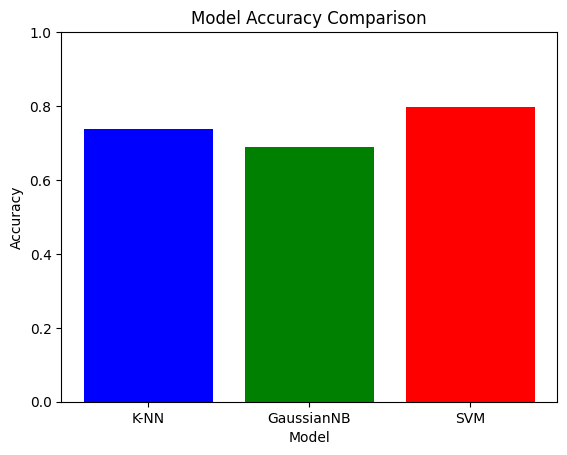

In [14]:
import matplotlib.pyplot as plt

models = ['K-NN', 'GaussianNB', 'SVM']
accuracies = [knn_accuracy, naive_accuracy, svm_accuracy]

plt.figure()
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Accuracy Comparison')

plt.show()

### PCA - Dimension Reduction To See The Word Embeddings in 2D Space